In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%cd "/home/volkan/Repos/multi-tier"
from data_analysis.helpers import *

def query_json_db(db_file, parameter_filters):
    with open(db_file, "r") as file:
        db_data = json.load(file)

    matching_entries_dict = {}
    matching_entries_params = []

    for entry_id, entry_data in db_data.items():
        if "parameters" in entry_data:
            parameters = entry_data["parameters"]
            if all(
                (
                    parameters.get(param) in value
                    if isinstance(value, list)
                    else parameters.get(param) == value
                )
                for param, value in parameter_filters.items()
            ):
                matching_entries_dict[entry_id] = entry_data
                matching_entries_params.append(parameters)

    return matching_entries_dict, matching_entries_params

def get_db_and_params(db_file, base_filters, case_filters):
    parameter_filters = deepcopy(base_filters)
    parameter_filters.update(case_filters)
    db, param_sets = query_json_db(db_file, parameter_filters)
    return db, param_sets

def get_data(topology, db_file, base_filters, case_filters, seeds, metric):
    db, param_sets = get_db_and_params(db_file, base_filters, case_filters)
    param_list = dictsToParamSets(param_sets)
    return getDataFieldSumAvgsAcrossSeeds(topology, db, param_list, seeds[0], seeds[1], metric)


/home/volkan/Repos/multi-tier


### Delay vs. Cost Trade-off

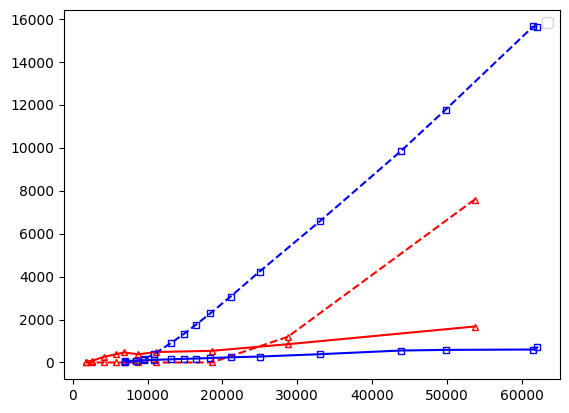

In [31]:
topology = "watts"

base_filters = {
    "request_rate": 15,
    "request_dist_param": 0.75,
}
seeds = [[1,2],[1,2,3,4,5]]

case_filters_list = [
    {
        "fwd_pol": "vip",
        "cache_pol": "mvip",
        "vip_slot_len": 4,
        "cache_capacities": [[5,200]]
    },
    {
        "fwd_pol": "lrt",
        "cache_pol": "palfu",
        "cache_capacities": [[5,100]]
    },
]

db_files_list = [
    f'sim_outputs/mt_pen_vip_{topology}_db.json',
    f'sim_outputs/mt_pen_palfu_{topology}_db.json',
]

pen_weights_list = [
    [0, 0.25, 0.5, 1, 1.5, 2.5, 3.75, 5, 7.5, 10],
    [0, 2.5, 3.75, 5, 10, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200],
]

delay_data = []
cost_data = []
first_tier_hits_data = []
second_tier_hits_data = []
for case_filters, db_file in zip(case_filters_list, db_files_list):
    delay_data.append(get_data(topology, db_file, base_filters, case_filters, seeds, "delay"))
    read_cost = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_read_penalties")
    write_cost = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_write_penalties")
    cost_data.append(np.sum(read_cost + write_cost, axis=1))
    hits = get_data(topology, db_file, base_filters, case_filters, seeds, "cache_replacements")
    first_tier_hits, second_tier_hits = np.hsplit(hits, 2)
    first_tier_hits_data.append(first_tier_hits)
    second_tier_hits_data.append(second_tier_hits)


fig, ax = plt.subplots()

ax.plot(cost_data[0], first_tier_hits_data[0], "-r^", fillstyle="none", markersize=5)
ax.plot(cost_data[0], second_tier_hits_data[0], "--r^", fillstyle="none", markersize=5)
ax.plot(cost_data[1], first_tier_hits_data[1], "-bs", fillstyle="none", markersize=5)
ax.plot(cost_data[1], second_tier_hits_data[1], "--bs", fillstyle="none", markersize=5)
ax.legend()